# S&P500 Forecasting

- **Autores:** Guilherme Magalhães, João Baptista, Francisco Martins, Nuno Moreira
- **Universidade:** Faculdade de Ciências da Universidade do Porto
- **Cadeira:** Laboratório de Inteligência Artificial e Ciência de Dados (CC3044)

## Problema

No contexto da cadeira de LABIACD (CC3044), foi-nos pedido para desenvolver um modelo de aprendizagem computacional, capaz de prever os preços futuros das ações (stocks) do índice S&P500, e aplicar métodos de otimização para selecionar o melhor conjunto de stocks para investimento diário.

## Contexto Cronológico

No decorrer deste projeto, simulamos um contexto de trabalho em que, no final de dezembro de 2023, um investidor nos pediu um programa capaz de prever os preços das ações do índice S&P500, para todos os dias de janeiro de 2024. Assim, elaboramos um modelo que combina previsões baseadas em dados históricos (desde janeiro de 2013 até dezembro de 2023) com técnicas de otimização, para maximizar o retorno, criando uma solução para os desafios financeiros do mundo real.

## Introdução

### **Portfolio**

Vamos simular a performance dos modelos no mês de janeiro de 2024. Iremos realizar a previsão de crescimento de cada empresa em cada dia desse mês e usar o algoritmo Monte Carlo para o simular. No final, obtemos o portfolio das empresas, baseado na melhor simulação, de acordo com os nossos dados.

### Restrições do Investimento

- Montante Inicial: 10000 USD
- Volume Máximo de Stocks para Comprar (por dia): 100
- Custo da Operação: 1 USD

##### Imports Necessários e Funções para Guardar e Carregar Dados

In [5]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle
import os

pd.options.mode.copy_on_write = True

def save_pkl(data, path):
    try:
        with open(path, "wb") as saved_data:
            pickle.dump(data, saved_data)
    except:
        print('Fail to save data')

def load_pkl(path):
    try:
        with open(path, "rb") as loaded_data:
            to_return = pickle.load(loaded_data)
        return to_return
    except:
        print('Fail to load data')
        return None
    
index_dates = ['start','2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08',
    '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-16',
    '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23',
    '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30']

### Previsão dos Modelos

Vamos prever qual será o crescimento de cada empresa no final do dia em relação ao início. Para este passo, utilizamos os modelos de previsão treinados com os dados históricos desde janeiro de 2013 até dezembro de 2023.

In [6]:
path_simulate = "data/simulation/"
simulate_df = os.listdir(path_simulate)
models = os.listdir("models_deviation")

if not os.path.exists("data/predict/"):
    os.mkdir("data/predict/")

predictores = ["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day","deviation"]


df_prev = pd.DataFrame()
for i in range(len(simulate_df)):
    data_prever =  pd.read_csv(path_simulate+simulate_df[i],index_col=0)
    model = load_pkl(f"models_deviation/{models[i+1]}")
    
    
    for company in data_prever["ticker"].unique():
        # para manter a data da previsao do modelo
        index_dates = ['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08',
       '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-16',
       '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23',
       '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30']
        
        data = data_prever[data_prever["ticker"] == company]
        predicted = model.predict(data[predictores])
        
        df = pd.DataFrame({'ticker': [company] * len(index_dates),
                           'predict': predicted,
                           'real': data["target"].to_numpy(),
                           'sector':simulate_df[i].split(".")[0]},
                          index=pd.to_datetime(index_dates))
        df_prev = pd.concat([df_prev,df])

df_prev.to_csv(f"data/predict/all_join.csv")
    

### Simular Monte Carlo

Na simulação, usamos a estratégia de day-trading, que consiste em comprar um stock no início do dia e vender no final com o objetivo de maximizar o lucro.

Realizamos 25000 simulações, cada uma a simular um investidor no mês de janeiro de 2024. Cada um desses investidores vai recolher a previsão dos modelos para as empresas naquele dia e das 20 empresas que apresentam maior crescimento escolher algumas para investir, sendo que tem de investir sempre um minimo de 600€.

No final das simulações, selecionamos a que apresenta o retorno total mais elevado, de acordo com as nossas previsões.

In [7]:
predicted_returns = pd.read_csv("data/predict/all_join.csv",index_col=0)

initial_budget = 10000
transaction_fee = 1
max_stocks_per_day = 100

num_simulations = 25000

def simulate_strategy(predicted_returns, budget, max_stocks, transaction_fee):
    real_daily_values = []
    real_cash = budget
    
    pred_daily_values = []
    cash = budget
    
    history_bought_stocks = {}

    days_to_simulate = predicted_returns.index.unique()
    for i in range(len(days_to_simulate)):
        day = days_to_simulate[i]   
        daily_bought = 0

        portfolio = {}  # guardar a quantidade de stock comprado
        day_info = predicted_returns[predicted_returns.index == day]

        # apenas manter as 20 empresas que prevemos maior crescimento, escolhendo em qual investir (baseado em pesos)
        day_info = day_info.sort_values(by='predict', ascending=False).iloc[:20] 

        # cria pesos para tornar mais provavel escolher os stocks com maior previsao de crescimento
        day_info['weights'] = day_info['predict'] / day_info['predict'].sum()

        # tickers para a compra
        buy_candidates = day_info[day_info['predict'] > 0][['ticker', 'weights']].copy()
        
        
        
        # comprar stocks no inicio do dia caso ainda tenha cash disponivel
        for j in range(6):
            if cash < 600:
                break
            elif cash//3 <= 600: 
                price = 600
            else: 
                price = random.randint(600,int(cash//3))
            
            company = random.choices(buy_candidates['ticker'].tolist(), weights=buy_candidates['weights'].tolist(), k=1)[0]

            # remover a empresa das disponiveis pois ja comprou 
            buy_candidates = buy_candidates.loc[buy_candidates['ticker'] != company]


            cash -= price
            real_cash -= price
            portfolio[company] = (price - transaction_fee)

            daily_bought += 1
            if daily_bought >= max_stocks:
                break  # atingimos o limite diario

        history_bought_stocks[day] = portfolio
     
        # valor real usado para atualizar o cash e o valor do investimento
        # como nao fazemos a previsao se o stock vai subir ou descer entre dias, vamos vender tudo hoje no final do dia
 
        for company in portfolio.keys():
            real_change = round(day_info.loc[day_info["ticker"] == company, "real"].to_numpy()[0],6)
            real_cash += round(portfolio[company] * (real_change + 1),2)

            pred_change = round(day_info.loc[day_info["ticker"] == company, "predict"].to_numpy()[0],6)
            cash += round(portfolio[company] * (pred_change + 1),2)
        del portfolio

        # guardar o valor do portfolio on final do dia
        real_daily_values.append(real_cash)
        pred_daily_values.append(cash)


    return real_daily_values[-1], real_daily_values, pred_daily_values[-1], pred_daily_values, history_bought_stocks

real_results = []
real_daily_portfolios = []
pred_results = []
pred_daily_portfolios = []
history_stocks = []

for _ in range(num_simulations):
    real_final_value, real_daily_value, pred_final_value, pred_daily_value, history = simulate_strategy(predicted_returns, initial_budget, max_stocks_per_day, transaction_fee)

    real_results.append(real_final_value)
    real_daily_portfolios.append(real_daily_value)
    pred_results.append(pred_final_value)
    pred_daily_portfolios.append(pred_daily_value)
    history_stocks.append(history)


## Analisar Resultados

Vamos analisar quais foram as 5 melhores simulações com base nos retornos previstos, isto é, 
- Se os retornos previstos pelos modelos fossem os reais qual era o valor final do portfólio 
- Qual a comparação com a realidade, se escolhessemos as ações tomadas nessa simulação, comprassemos os mesmos stocks e a mesma quantidade nos mesmos dias

In [8]:
# top 5 resultados previstos e comparar ao valor real
top_5_val = [0] * 5
top_5_id = [0] * 5

for i in range(len(pred_results)):
    if pred_results[i] > top_5_val[0]:
        top_5_val[4] = top_5_val[3]
        top_5_val[3] = top_5_val[2]
        top_5_val[2] = top_5_val[1]
        top_5_val[1] = top_5_val[0]
        top_5_val[0] = pred_results[i]
        
        top_5_id[4] = top_5_id[3]
        top_5_id[3] = top_5_id[2]
        top_5_id[2] = top_5_id[1]
        top_5_id[1] = top_5_id[0]
        top_5_id[0] = i
        
    elif pred_results[i] > top_5_val[1]:
        top_5_val[4] = top_5_val[3]
        top_5_val[3] = top_5_val[2]
        top_5_val[2] = top_5_val[1]
        top_5_val[1] = pred_results[i]
        
        top_5_id[4] = top_5_id[3]
        top_5_id[3] = top_5_id[2]
        top_5_id[2] = top_5_id[1]
        top_5_id[1] = i
        
    elif pred_results[i] > top_5_val[2]:
        top_5_val[4] = top_5_val[3]
        top_5_val[3] = top_5_val[2]
        top_5_val[2] = pred_results[i]
        
        top_5_id[4] = top_5_id[3]
        top_5_id[3] = top_5_id[2]
        top_5_id[2] = i
        
    elif pred_results[i] > top_5_val[3]:
        top_5_val[4] = top_5_val[3]
        top_5_val[3] = pred_results[i]
        
        top_5_id[4] = top_5_id[3]
        top_5_id[3] = i
        
    elif pred_results[i] > top_5_val[3]:
        top_5_val[4] = pred_results[i]
        
        top_5_id[4] = i

### A Melhor Simulação

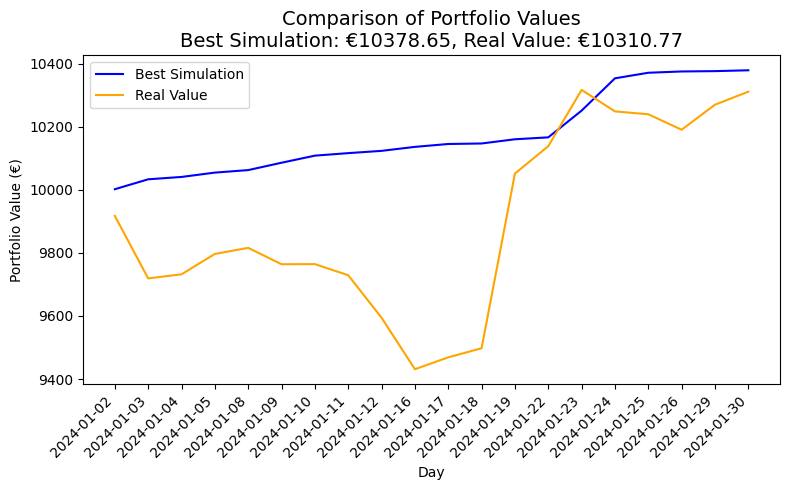

In [10]:

plt.figure(figsize=(8, 5))

plt.plot(pred_daily_portfolios[top_5_id[0]], label="Best Simulation", color="blue")
plt.plot(real_daily_portfolios[top_5_id[0]], label="Real Value", color="orange")

plt.title(f"Comparison of Portfolio Values\nBest Simulation: €{pred_results[top_5_id[0]]:.2f}, Real Value: €{real_results[top_5_id[0]]:.2f}", fontsize=14)
plt.xlabel("Day")
plt.ylabel("Portfolio Value (€)")
plt.xticks(range(len(index_dates)), index_dates, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

Após analisar a nossa melhor simulação, concluímos que, segundo as nossas previsões, o lucro total obtido, para um montante inicial de 10000 USD, seria 3,78% (10378.65 USD). Passado o mês de janeiro inteiro, verificamos que a nossa melhor simulação tinha resultado num retorno total **real** de 10310.77 USD, representando assim 3,10% de lucro total. Assim, podemos concluir que o portfolio da nossa melhor simulação gerou lucro, sendo que o valor previsto está bastante próximo do valor real.

As ações compradas diariamente

In [9]:
print("Quais Stocks comparar e quantidade por dia")
print("<lembrar, comprar no inicio do dia e vender no final>")
for day, trades in history_stocks[top_5_id[0]].items():
    print(f"{day}: {trades}")

Quais Stocks comparar e quantidade por dia
<lembrar, comprar no inicio do dia e vender no final>
2024-01-02: {'TSLA': 995, 'KLAC': 1819, 'CDW': 1173, 'OKE': 1525, 'ZBRA': 920, 'PANW': 906}
2024-01-03: {'MRNA': 3117, 'ABBV': 2269, 'ENPH': 1021, 'MOH': 627, 'TSLA': 777, 'ZBRA': 711}
2024-01-04: {'ZBRA': 3273, 'ODFL': 1296, 'LLY': 1355, 'TSLA': 894, 'DAY': 813, 'PAYC': 743}
2024-01-05: {'MRNA': 2893, 'BKR': 840, 'CVX': 1032, 'MOH': 1435, 'ULTA': 826, 'HES': 671}
2024-01-08: {'ZBRA': 1875, 'ENPH': 2280, 'ON': 978, 'TPL': 1184, 'APA': 1173, 'BKR': 683}
2024-01-09: {'ENPH': 776, 'CTRA': 2599, 'DVN': 2079, 'EQT': 1424, 'HAL': 943, 'VLO': 666}
2024-01-10: {'MRNA': 2966, 'WST': 1632, 'RMD': 653, 'PODD': 1348, 'DXCM': 782, 'TMO': 644}
2024-01-11: {'BSX': 3270, 'FANG': 1957, 'MRNA': 965, 'ISRG': 852, 'CRL': 752, 'RMD': 690}
2024-01-12: {'ALGN': 624, 'CVX': 1711, 'CTLT': 2442, 'APA': 1386, 'MPC': 1198, 'ENPH': 884}
2024-01-16: {'MRNA': 2575, 'ENPH': 2408, 'SLB': 1217, 'SMCI': 1133, 'DAL': 625, 'CR

### Top 5 Simulações

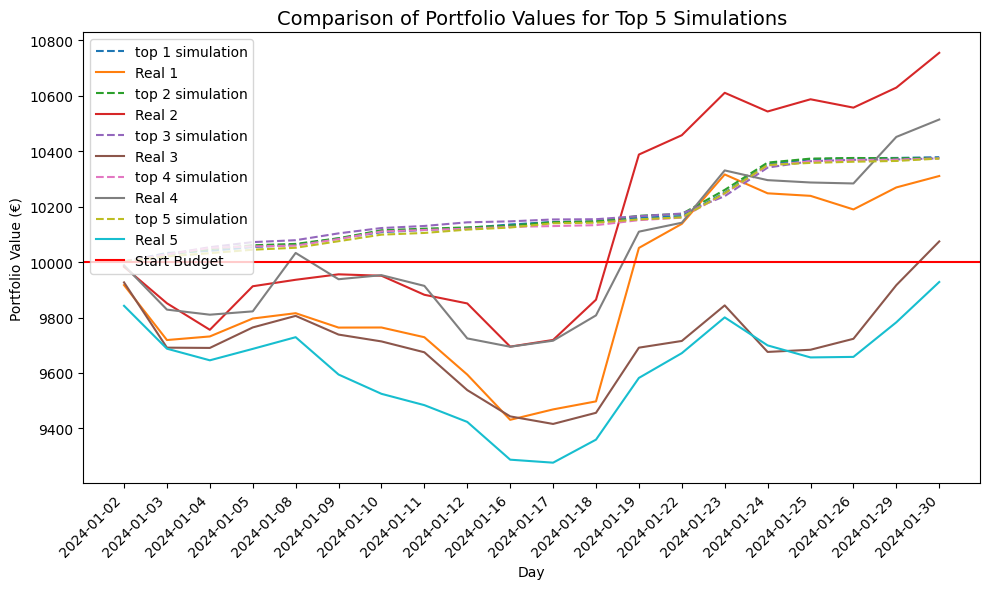

In [11]:
plt.figure(figsize=(10, 6))

for i, portfolio_id in enumerate(top_5_id):
    plt.plot(pred_daily_portfolios[portfolio_id], label=f"top {i+1} simulation", linestyle='--')
    plt.plot(real_daily_portfolios[portfolio_id], label=f"Real {i+1}")
    
plt.axhline(y=10000, color='red', linestyle='-', label="Start Budget")
plt.title("Comparison of Portfolio Values for Top 5 Simulations", fontsize=14)
plt.xlabel("Day")
plt.ylabel("Portfolio Value (€)")


plt.xticks(range(len(index_dates)), index_dates, rotation=45, ha='right')

plt.legend(loc="upper left")

plt.tight_layout()

plt.show()

### As simulações e o valor real

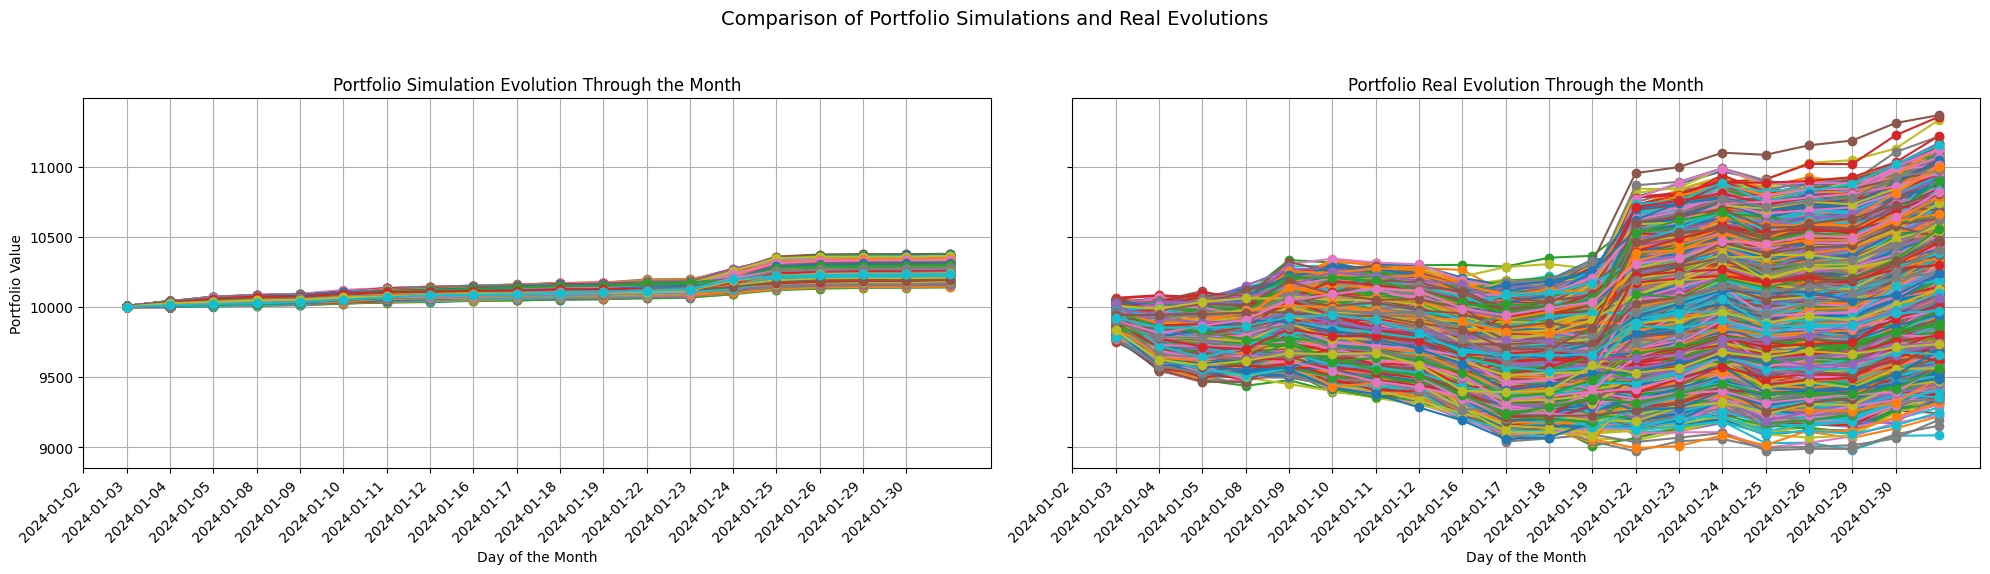

In [12]:

days = range(1, len(pred_daily_portfolios[0]) + 1)
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True, sharey=True)


for i, portfolio in enumerate(pred_daily_portfolios):
    axes[0].plot(days, portfolio, label=f'Portfolio {i + 1}', marker='o')
axes[0].set_title("Portfolio Simulation Evolution Through the Month")
axes[0].set_xlabel("Day of the Month")
axes[0].set_ylabel("Portfolio Value")
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xticks(range(len(index_dates)))
axes[0].set_xticklabels(index_dates, rotation=45, ha='right')

for i, portfolio in enumerate(real_daily_portfolios):
    axes[1].plot(days, portfolio, label=f'Portfolio {i + 1}', marker='o')
axes[1].set_title("Portfolio Real Evolution Through the Month")
axes[1].set_xlabel("Day of the Month")
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xticks(range(len(index_dates)))
axes[1].set_xticklabels(index_dates, rotation=45, ha='right')


fig.suptitle("Comparison of Portfolio Simulations and Real Evolutions", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Crescimento do Portfólio

In [26]:
banca_inicial = 10000
prev_total = 0
real_total = 0
for i in range(5):
    print()
    cresimento_previsto = 100 * (pred_results[top_5_id[i]] - banca_inicial) / banca_inicial
    prev_total += cresimento_previsto/5
    cresimento_real = 100 * (real_results[top_5_id[i]] - banca_inicial) / banca_inicial
    real_total += cresimento_real/5
    print("A percentagem de crescimento Total do Portfólio ao final do mês de janeiro")
    print(f"Seguindo a {i} melhor simulação")
    print(f"A percentagem de crescimento Previsto: {cresimento_previsto:.3f}%")
    print(f"A percentagem de crescimento Real: {cresimento_real:.3f}%")
print("\nCaso optasse por dividir a banca e investir a mesma quantidade nas 5 melhores simulações iria ter um lucro de: ")
print(f"A percentagem de lucro previsto seria de : {prev_total:.3f}%")
print(f"A percentagem de lucro real seria de : {real_total:.3f}%")


A percentagem de crescimento Total do Portfólio ao final do mês de janeiro
Seguindo a 0 melhor simulação
A percentagem de crescimento Previsto: 3.786%
A percentagem de crescimento Real: 3.108%

A percentagem de crescimento Total do Portfólio ao final do mês de janeiro
Seguindo a 1 melhor simulação
A percentagem de crescimento Previsto: 3.753%
A percentagem de crescimento Real: 7.552%

A percentagem de crescimento Total do Portfólio ao final do mês de janeiro
Seguindo a 2 melhor simulação
A percentagem de crescimento Previsto: 3.745%
A percentagem de crescimento Real: 0.748%

A percentagem de crescimento Total do Portfólio ao final do mês de janeiro
Seguindo a 3 melhor simulação
A percentagem de crescimento Previsto: 3.742%
A percentagem de crescimento Real: 5.146%

A percentagem de crescimento Total do Portfólio ao final do mês de janeiro
Seguindo a 4 melhor simulação
A percentagem de crescimento Previsto: 3.737%
A percentagem de crescimento Real: -0.716%

Caso optasse por dividir a b